In [74]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
import seaborn as sns


In [5]:
pandas_df = pd.read_pickle("./raw_weekly_df.pkl")
dask_df = dd.from_pandas(pandas_df, npartitions=8)

In [6]:
(pandas_df.info(memory_usage="Deep"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 7 columns):
 #   Column    Dtype         
---  ------    -----         
 0   dept_id   category      
 1   cat_id    category      
 2   item_id   category      
 3   state_id  category      
 4   store_id  category      
 5   datetime  datetime64[ns]
 6   sales     float32       
dtypes: category(5), datetime64[ns](1), float32(1)
memory usage: 117.5 MB


In [7]:
'''
The only place where we can save memory is potentially changing the float32 column to a less data intensive float 
type. Everything else is a category or datetime.
'''

'\nThe only place where we can save memory is potentially changing the float32 column to a less data intensive float \ntype. Everything else is a category or datetime.\n'

In [8]:
#Downcast in order to save memory
#TODO comments added in .py
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            df[cols[i]] = pd.to_numeric(df[cols[i]], downcast='integer')
        elif 'float' in str(t):
            df[cols[i]] = pd.to_numeric(df[cols[i]], downcast='float')
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df 

In [9]:
'''
The above downcast won't actually help, since the only place where our data can save any memory is float, and 
the above method just downcasts it to a float32, which is already the case. But this could be useful for future 
datasets. 
'''

"\nThe above downcast won't actually help, since the only place where our data can save any memory is float, and \nthe above method just downcasts it to a float32, which is already the case. But this could be useful for future \ndatasets. \n"

In [10]:
downcast(pandas_df).info(memory_usage="Deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 7 columns):
 #   Column    Dtype         
---  ------    -----         
 0   dept_id   category      
 1   cat_id    category      
 2   item_id   category      
 3   state_id  category      
 4   store_id  category      
 5   datetime  datetime64[ns]
 6   sales     float32       
dtypes: category(5), datetime64[ns](1), float32(1)
memory usage: 117.5 MB


In [ ]:
#TODO when splitting up tasks in multiple functions, ask if it makes the code easier or harder to read. 
# IMO, these splits make the code harder to understand
def get_dataframe_of_item_ids(dataframeinput):
    #TODO can't assume 'item_id' can be hardcoded
    x = (((dataframeinput[['item_id']]).drop_duplicates()))
    newdataframe = pd.DataFrame(x)
    return (newdataframe)

#example = (get_dataframe_of_item_ids(pandas_df))


def get_dataframe_of_store_ids(dataframeinput):
    #TODO hard-coding
    #TODO delete commented code
    x = (((dataframeinput[['store_id']]).drop_duplicates()))
    #newdataframe = pd.Dataframe(x)
    return (x)


def convert_dataframe_to_list(dataframe):
    return (dataframe.values.tolist())
#print(get_dataframe_of_store_ids(pandas_df))


def find_item_and_store_combo(dataframe, store_id, item_id):
    #TODO nice job on the descriptive variable names!
    #TODO hardcoding
    #TODO why cast to a dict only to cast it back to a dataframe? seems like there's a better way
    x = (dataframe[(dataframe['store_id'] == store_id) & (dataframe['item_id'] == item_id)]).to_dict()
    subsetdataframe = pd.DataFrame(x)
    return(subsetdataframe)
    
    
#I tried upsampling in order to find the weeks that are missing by adding those rows in and filling them in with NaN
#However, for some reason, after '2011-01-31' instead of '2011-02-07', it starts with '2011-02-06' so it throws it off
#TODO can you show me screenshots of what you mean? the data was aggregated using W-MON format, maybe that will solve your issue
#TODO don't hardcode things like date formats since they're likely to change
#TODO don't need parentheses around return (minor style issue)
def upsampling(dataframeinput):
    return(dataframeinput.set_index('datetime').resample('w').asfreq())

#TODO hardcoding
def find_missing_weeks_for_specific_combo(dataframeinput):
    return(dataframeinput[dataframeinput['dept_id'].isna()])


#The following function is quite inefficient since it has quadratic runtime O(n^2), but I'm not sure how to fix this
def find_missing_weeks_in_entire_dataframe(dataframe):
    #TODO if you'll never use any of these functions again, define them within the scope of this function so they aren't hanging out in memory
    dataframe_of_store_ids = get_dataframe_of_store_ids(dataframe)
    store_ids = convert_dataframe_to_list(dataframe_of_store_ids)
    dataframe_of_item_ids = get_dataframe_of_item_ids(dataframe)
    item_ids = convert_dataframe_to_list(dataframe_of_item_ids)
    
    #TODO after you upsample and fill the missing rows with NaNs, you should be able to use .grouby(grouping_cols).count() to get the number of missing. no for-loops!
    for store in store_ids:
        store_id = ''.join(store)
        print(store_id)
        for item in item_ids:
            item_id = ''.join(item)
            print('helo')
            print(item_id)
            combo = (find_item_and_store_combo(pandadataframe, store_id, item_id))
            print(combo)
            #psampled = upsampling(combo)
            #mssing_weeks = find_missing_weeks(upsampled)
            #t([store_id, item_id, missing_weeks])
            
find_missing_weeks_in_entire_dataframe(pandadataframe)

#The following is just for one specific combination of product and store which isn't super slow
"""
combo = find_item_and_store_combo(pandas_df, 'CA_1', 'FOODS_1_001')
upsamplingresult = upsampling(combo)


for item in example.values.tolist():
    print((''.join(item))=='FOODS_1_001')
    item_id = ''.join(item)
    combo = (find_item_and_store_combo(pandas_df, 'CA_1', item_id))
    upsampled = upsampling(combo)
    missing_weeks = find_missing_weeks(upsampled)
    print(['CA_1', item_id, missing_weeks])
    
"""

'\nsales_series = pandas_df[\'sales\']\nmax_sale = sales_series.max()\nprint(max_sale)\nax = pandas_df.hist(column=\'sales\', by="state_id",bins=100, figsize=(12,8), range=[0,50])\n'

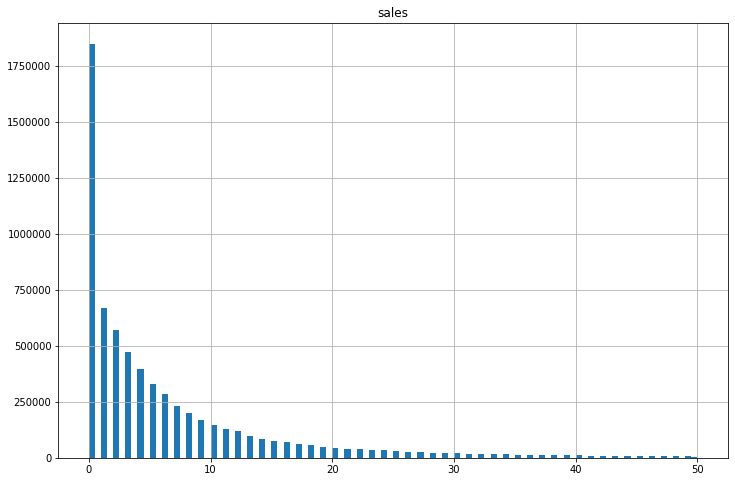

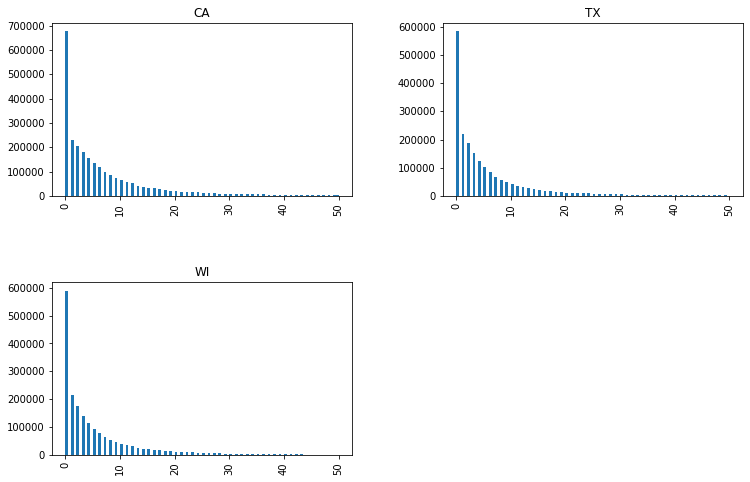

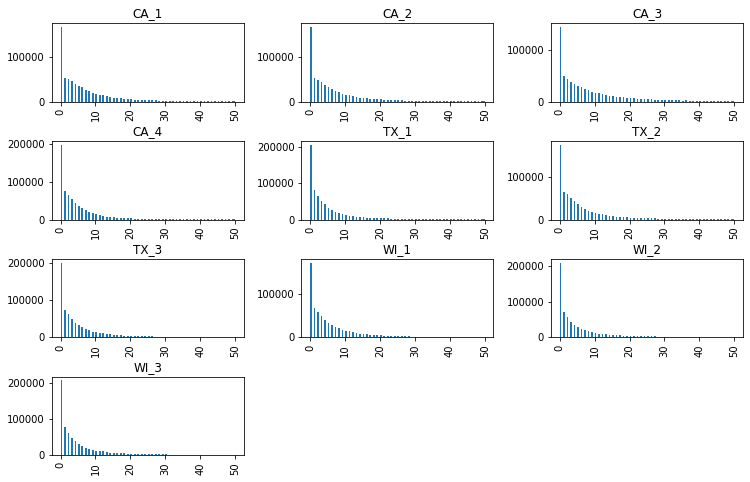

In [73]:
#TODO move all graphing functions to /src/exploration.py
#TODO nice job with the graphs! now tell me how to interpret them (what insights can you glean from what's shown below?)
def univariate_sales_histogram(pandadataframe):
    sales_series = pandadataframe['sales']
    max_sale = sales_series.max()
    (pandadataframe.hist(column='sales',bins=100, figsize=(12,8), range=[0,50]))
    
def bivariate_sales_by_state(pandadataframe):
    sales_series = pandadataframe['sales']
    max_sale = sales_series.max()
    pandadataframe.hist(column='sales', by="state_id",bins=100, figsize=(12,8), range=[0,50])

def bivariate_sales_by_store(pandadataframe):
    sales_series = pandadataframe['sales']
    max_sale = sales_series.max()
    pandadataframe.hist(column='sales', by="store_id",bins=100, figsize=(12,8), range=[0,50])

univariate_sales_histogram(pandas_df)
bivariate_sales_by_state(pandas_df)
bivariate_sales_by_store(pandas_df)

"""
sales_series = pandas_df['sales']
max_sale = sales_series.max()
print(max_sale)
ax = pandas_df.hist(column='sales', by="state_id",bins=100, figsize=(12,8), range=[0,50])
"""